# Exploring Housing Data

In this notebook we will learn how to explore data using Jupyter Notebooks. If you have not already, you should install the following packages: `jupyter`, `matplotlib`, `numpy`, `pandas`, `scikit-learn`. To install using the command line, first make sure you have a current version of `pip` with the following, 
```
$ python3 -m pip install pip --user --upgrade
```
(the user option is needed on a Mac).
Once `pip` is updated you can run
```
$ python3 -m pip install --user jupyter matplotlib numpy pandas scipy scikit-learn
```

If you are using `Anaconda Navagator`, select the environment you want to use (do not use `base (root)`, create a new one), and then select the packages. 

At this point we could import all the packages at once, instead we will import them as needed. 

## The Problem

The Hamilton Econ department is interested real estate investments in California (currently they are only investing in Kansas). Before they move to a new state, they would like to be able to predict the housing price of a given district. As of now this process takes all summer as all the Econ professors have to fly out to Kansas and survey all the known properties to get an idea of the cost. As none of the professors desire to visit California, they have asked us to create a predictive model that would give a good estimate of the housing price without the need to leave the office. Further, their estimates are usually off by more than 20%. So anything close to that would be desired. 

It is worth keeping in mind that our model is just one part of the pipeline for real estate investments. The Econ department will be creating an investment analysis ML model that will take our model (and other signals) as an input. 

![](./images/pipeline.png)

We will be working with housing price data from the California census bureau. Each row in our file is associated to a "district" of about 600-3,000 people. As we will see, for each district in California, we can see the population, median income, median housing price, and more.  In order to be effective in our pipeline, we want to produce the district prices. 

## What type of problem is this?

Before starting any ML project, you should determine the type of project you are working on. For example, 

* Is it supervised, unsupervised, or reinforced?
* Is it a classification task or a regression task? (or something else?)
* Should we use batch learning or online learning?

The answers to these questions can be determined by how the problem is framed in the pipeline. This is why it is important to get as much detail from the client as possible. 

## How to measure performance?

Before we begin playing with the data, we should determine how we are going to evaluate our performance. A popular measure is the Root Mean Square Error (RMSE). It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors. 

$$
\text{RMSE}(\mathbf{X}, h) = \sqrt{\frac{1}{m}\sum\limits_{i=1}^{m}\left(h(\mathbf{x}^{(i)}) - y^{(i)}\right)^2}
$$

This function is a bit notation heavy, so let's try to unpack it. 

* $y^{(i)}$ is the label (or housing value) of the $i$th instance (or district). Essentially this is the correct answer that we are trying to approximate.
* Given an instance of our data (in our case a district), $\mathbf x^{(i)}$ is a column vector whose entries describe the features of the $i$th instance (or district). The labels are not included in this
* $\mathbf X$ is an $m \times n$ matrix whose $i$th row is $(\mathbf x^{(i)})^T$, the transpose of $\mathbf x^{(i)}$. 
* $m$ is the number of instances, i.e. rows in $\mathbf X$. 
* $h:\mathbb R^n\to \mathbb R$ is our prediction function (or hypothesis). For each instance in our data, $h(\mathbf x^{(i)})$ is our predicted value. Our goal is to make $h(\mathbf x^{(i)})$ very close to the value $y^{(i)}$. Another way of saying this is that we want $|h(\mathbf x^{(i)}) -y^{(i)}|$ close to zero. 

**Example:** Assume we have 2000 instances in our data set each with the 5 features, longitude, latitude, population, median income, and median house value. Here $m = 2000$ and the first instance might have a longitude of -118.29$^\circ$, latitude of 33.91$^\circ$, population of 1,416, median income of $\$38,327$, and median house value of $\$156,400$. Using the notation from above we have

\begin{align*}
  \mathbf{x}^{(1)} &= \begin{pmatrix}
  -118.29 \\
  33.91 \\
  1,416 \\
  38,372
  \end{pmatrix} \\ \\
  y^{(1)}&=156,400\\ \\
  \mathbf{X} &= \begin{pmatrix}
  (\mathbf{x}^{(1)})^T \\
  (\mathbf{x}^{(2)})^T\\
  \vdots \\
  (\mathbf{x}^{(1999)})^T \\
  (\mathbf{x}^{(2000)})^T
  \end{pmatrix} = \begin{pmatrix}
  -118.29 & 33.91 & 1,416 & 38,372 \\
  \vdots & \vdots & \vdots & \vdots \\
  \end{pmatrix}
\end{align*}


Another popular error is the Mean Absolute Error (MAE). This is really the same as the RMSE, but without the root and an absolute value instead of a square. Both of these are examples of something more general that we will discuss in the future. 

$$
\text{MAE}(\mathbf{X}, h) = \frac{1}{m}\sum\limits_{i=1}^{m}\left| h(\mathbf{x}^{(i)}) - y^{(i)} \right|
$$

For this problem we will use the RMSE. 

## Loading the data (finally)

In this folder there should be a folder called `housing_data`. Inside is a file `housing.csv` with the data we will be using. As mentioned before, we will be importing packages as needed. 

In [10]:
import pandas as pd
import numpy as np

housing = pd.read_csv("housing_data/housing.csv") # Imports csv as a pandas DataFrame
housing.head(50) # The DataFrame.head() function gives the first 5 instances and their features

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,1,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
1,2,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
2,3,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3,4,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
4,5,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN
5,6,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395,127900.0,INLAND
6,7,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839,500001.0,<1H OCEAN
7,8,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000,140200.0,INLAND
8,9,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242,95000.0,<1H OCEAN
9,10,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,500001.0,<1H OCEAN


We can also get more info about the nature of the data. 

In [3]:
housing.shape # Gives us the shape of the data

(16512, 11)

In [4]:
housing.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 11 columns):
id                    16512 non-null int64
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), int64(1), object(1)
memory usage: 1.4+ MB


Notice that `ocean_proximity` is an object, not a number. So we can get more info about that particular feature. 

In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

We can also get basic statistics on our numerical features. The function only looks at the features with numerical values. 

In [6]:
housing.describe()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,8256.500000,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724
std,4766.748158,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830
min,1.000000,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,4128.750000,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000
50%,8256.500000,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000
75%,12384.250000,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000
max,16512.000000,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


## Visualizing the data

Visualizing our data can help us find patterns that we can either use or ignore. Before we start visualizing, here is a bit of code that will help save our data. 

In [7]:
import os
def save_fig(fig_id, image_path="./images", tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(image_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This histogram below shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). Notice we are only seeing the features with numerical data. 

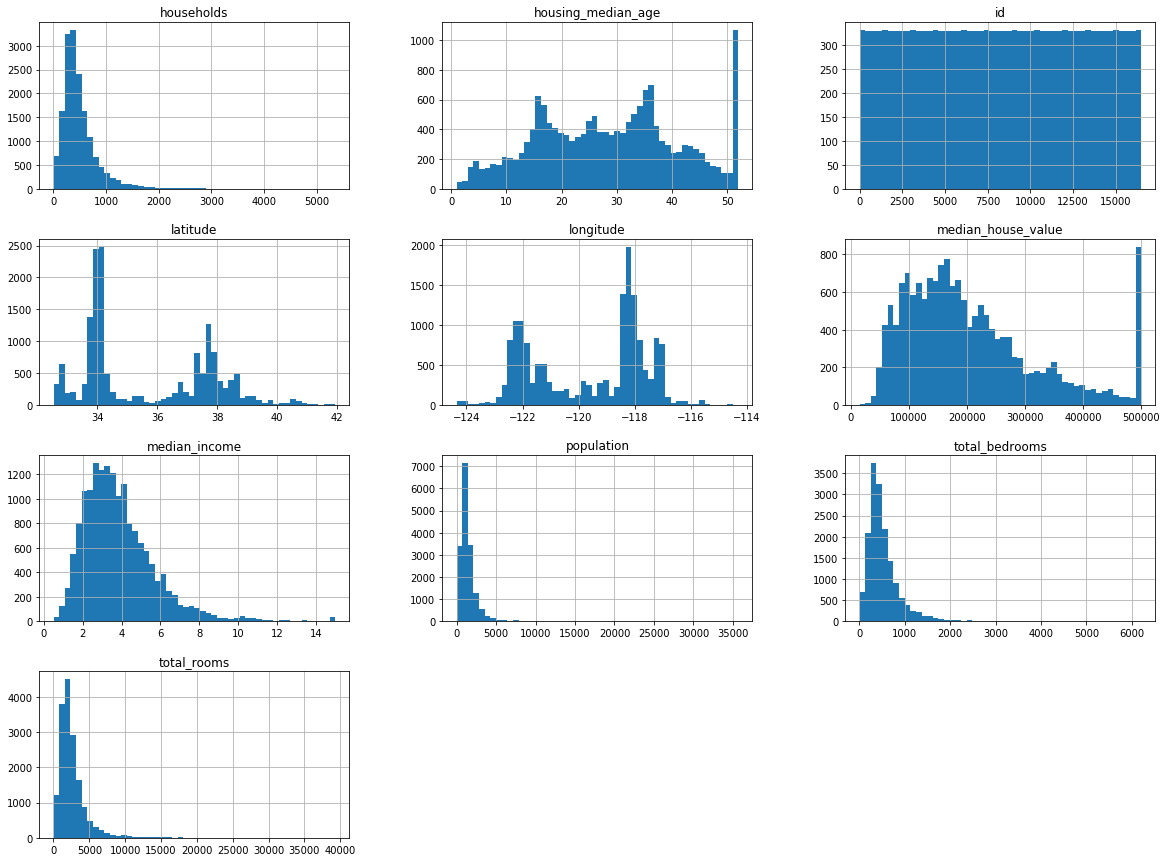

Saving figure first_histogram


<Figure size 432x288 with 0 Axes>

In [14]:
# The first line makes the plot show up in the jupyter notebook
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show() # You don't really need this line in a jupyter notebook
save_fig("first_histogram")

Things to notice in these histograms: 

1. The `median_income` looks funny. I'm quite certain people are not making $\$$3 per year. If we were working in a firm, we would have to contact to data collectors to see what this means. Thankfully the Econ department has informed us this is feature has been scaled and capped at 15.0001 above and .4999 below. Also, the values are in tens of thousands of dollars (i.e. 3 is $\$$30,000). 
2. The `housing_median_age` and the `median_house_value` were also capped (notice the tower on the right of both graphs). The `median_house_value` could be a major problem as this feature contains your labels. Turns out the data collector capped all the values at $\$$500,000. Turns out the Econ department does not care about values over the $\$$500,000 mark. If they did want precise estimates above $\$$500,000, then we have two options at this point
    1. Go collect the needed information yourself.
    1. Remove districts from both training and test sets that are at $\$$500,000. 
3. The scales of these features are not the same. 
4. The histograms are tail heavy; we want more of a normal distribution. The less normal the data is, the harder it is for ML algorithms to detect patterns. 

## Creating a test set

In this course you will not have to worry about creating your own test set, but if you plan on working on your own datasets, you should always split your data into a training set and a test set. Generally your test set should be about 20% of the data. Here are a couple of ways to do this. 

### Choose randomly

Here we use the `scikit-learn` package to create our two sets. We could write our own functions, but why? Notice the output of the function `train_test_split` is two datasets. Python is nice in that it allows us to assign two variable in one line. 

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Notice `train_test_split` takes our housing data as an input. We also defined two of the optional parameters, `test_size` and `random_state`. You can see what they do buy running the `help()` function. 

In [16]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float, int or None, optional (default=None)
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. If ``train_s

### Stratified sample

If you have a large amount of instances compared to your features, a random sampling of training and test sets might be ok. But we have to be careful of sampling bias when we create these two sets. For example, say we want to get the public opinion of a certain political figure. It is not possible to ask everyone in the country, but we can survey 1000 people. If we only ask white males, chances are we will get a different result than if we only surveyed the LGBTQ community. To solve this problem, we can partition the 1000 people surveyed into distinct groups (stratas) that represent demographics of the country as a whole (the keyword here is distinct groups, they cannot overlap). This process is called _stratified sampling_. 

Here is a recent article on the issue: [Facial Recognition Is Accurate, if You’re a White Guy](https://www.nytimes.com/2018/02/09/technology/facial-recognition-race-artificial-intelligence.html).

With our housing data, the Econ department has informed us that median income is a very important feature in predicting median house prices. So let's cut up the `median_income` attribute into five bins and store it as a new feature, `income_cat` (notice we have created a new feature column in housing, type in `housing.head()` to see).

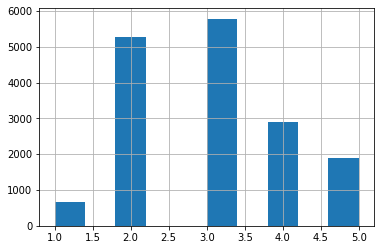

In [17]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.0,1.5,3.0,4.5, 6.0, np.inf], labels=[1,2,3,4,5])
housing['income_cat'].hist()

We want our training and test set to have this same distribution. To do this we will use `StratifiedShuffleSplit` from the `scikit-learn` package.

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

The cell below creates a new train and test set with the `income_cat` feature, and also defines a percent error function.

In [19]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
def my_percent_error(approx_set,exact_set,col,val):
    exact = (exact_set[col].value_counts() / len(exact_set))[val]
    approx = (approx_set[col].value_counts() / len(approx_set))[val]
    return abs(exact-approx)/exact*100

In [20]:
print("Percent error for random test\n")
for num in range(1,6):
    print("bin "+str(num)+" | "+str(my_percent_error(test_set, housing,"income_cat",num)))

Percent error for random test

bin 1 | 1.9934903058562417
bin 2 | 1.1575594318555285
bin 3 | 1.639850956016212
bin 4 | 0.7394358396897757
bin 5 | 0.03476314183794755


In [21]:
print("Percent error for stratified test\n")
for num in range(1,6):
    print("bin "+str(num)+" | "+str(my_percent_error(strat_test_set, housing,"income_cat",num)))

Percent error for stratified test

bin 1 | 0.285730849821519
bin 2 | 0.01816530426884916
bin 3 | 0.000894301557539273
bin 4 | 0.052511520241272855
bin 5 | 0.03476314183794755


Let's remove the `income_cat` feature from our sets and use the stratified sets. 

In [22]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    
housing = strat_train_set.copy()

## More visualizing

Now that we have our training and test sets ready to go, it is time to visualize the data a bit more. Keep in mind we do not want to touch our test set until we are sure our model is good to go. We use the test set to calculate the RMSE and use this value to describe our model. It is tempting to train with the test set, but then our model will fail in the wild. 

It's time to plot our districts. 

Saving figure first_scatter_plot


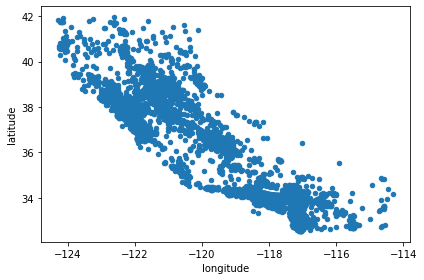

In [23]:
housing.plot(kind="scatter",x="longitude",y="latitude")
save_fig("first_scatter_plot")

A little fancier. Use the `help()` function to find out what `alpha` does.

Saving figure second_scatter_plot


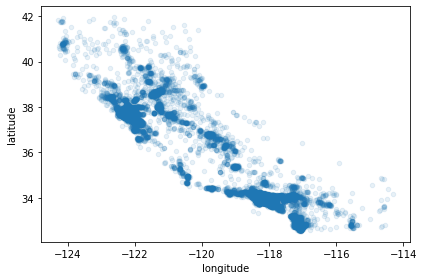

In [24]:
housing.plot(kind="scatter", x="longitude",y="latitude", alpha=.1)
save_fig("second_scatter_plot")

Now let's get super fancy. The radius of each circle represents the district's population (option `s`), and the color represents the price (option `c`). We will use a predefined color map (option `cmap`) called `jet`, which ranges from blue (low values) to red (high prices). 

Saving figure housing_prices_scatterplot


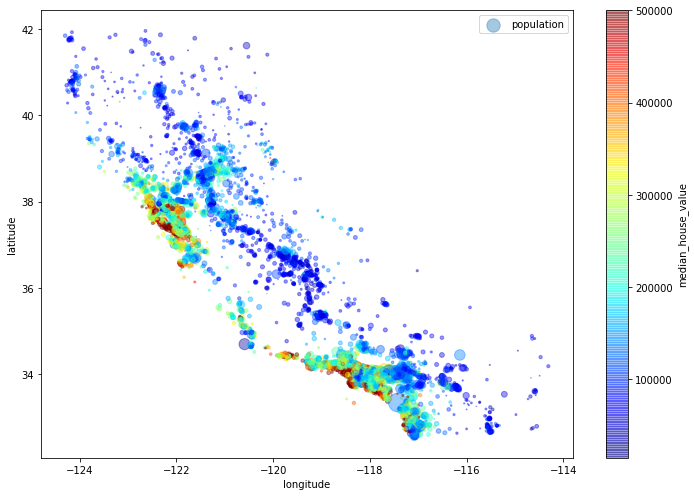

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude", sharex=False, alpha=0.4, 
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True            
            )
plt.legend()
save_fig("housing_prices_scatterplot")

Let's just go crazy now. 

Saving figure california_housing_prices_plot


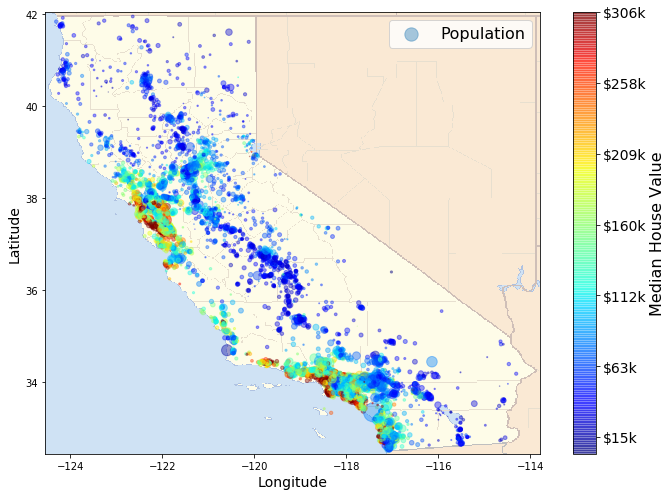

In [27]:
import matplotlib.image as mpimg
california_img=mpimg.imread('./images/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

Feel free to switch out the value for `s` and `c` to see if you can find interesting correlations on the features. 

## Visualizing correlations

A quick way to find correlations with python is with the correlation matrix. This creates the `standard correlation coefficient` (also called Pearson's r) between every pair of numerical features. These coefficients are values between -1 and 1. If the coefficient between two features is close 1, this means the features have a strong positive correlation (moving the same direction). If the value is close to -1, this means the features have a strong negative correlation (moving away from each other).

Can you think of some math operation that behaves similarly? 

In [28]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687535
total_rooms           0.138874
housing_median_age    0.110153
households            0.066931
total_bedrooms        0.050820
id                    0.023921
population           -0.025969
longitude            -0.047642
latitude             -0.141413
Name: median_house_value, dtype: float64

Another way to see correlations is to use the `scatter_matrix` from `pandas.plotting`. We don't have to define the attributes to use, but if we didn't it would compare all 11 with themselves, giving 121 plots. So to limit our plots, we are using the promising ones from the `corr_matrix` above. 

Notice that the main diagonal would be full of straight lines if we plotted each feature with itself. So instead, `pandas` displays a histogram of each attribute (other options available, just use the `help()` function). 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122fa0b00>,
      dtype=object)

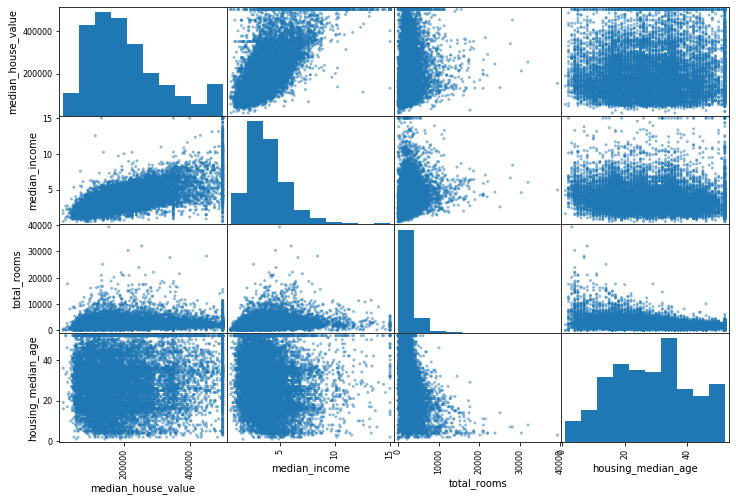

In [29]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

Looking at the top row, we see that `median_income` seems to have a strong correlation with `median_house_value`. We can zoom in on this plot. 

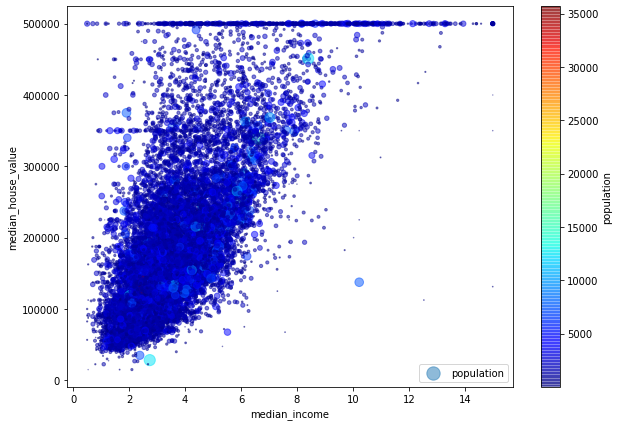

In [36]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", sharex=False, alpha=0.5, 
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="population", cmap=plt.get_cmap("jet"), colorbar=True
            )

There seem to be a few data quarks here. Can you find them?

## Making new data from old

It's possible to create new features from the old ones. Think of ratios or distances. `pandas` makes this simple with built in broadcasting. Basically, we can do operations on rows and columns and the results with be broadcasted across the rows and columns as we would "expect". Here are some examples. 

In [37]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]
housing.head()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
12620,12621,-118.31,33.81,23.0,3942.0,748.0,1679.0,711.0,4.1169,362600.0,<1H OCEAN,5.544304,0.189751,2.361463
3778,3779,-119.43,36.63,25.0,1784.0,312.0,904.0,303.0,3.6250,107600.0,INLAND,5.887789,0.174888,2.983498
7850,7851,-120.13,36.87,32.0,2089.0,468.0,1765.0,427.0,2.2340,61700.0,INLAND,4.892272,0.224031,4.133489
10381,10382,-117.28,33.22,13.0,2832.0,542.0,1065.0,531.0,2.3844,98600.0,<1H OCEAN,5.333333,0.191384,2.005650
1401,1402,-122.03,36.97,51.0,924.0,232.0,488.0,228.0,2.1964,234400.0,NEAR OCEAN,4.052632,0.251082,2.140351


Notice the new columns on the end! We can now look at the correlations. 

In [25]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687535
rooms_per_household         0.165248
total_rooms                 0.138874
housing_median_age          0.110153
households                  0.066931
total_bedrooms              0.050820
id                          0.023921
population                 -0.025969
population_per_household   -0.026431
longitude                  -0.047642
latitude                   -0.141413
bedrooms_per_room          -0.258966
Name: median_house_value, dtype: float64

## Data is ready for cleaning

Now that we have become familiar with our data and know what features/ districts we want to add/deleted, we can get ready for cleaning and training. 